In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D
from tensorflow.keras.layers import SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
# Loading the DSs 
df_test = pd.read_csv('cleaned_datatest.csv')
df_val = pd.read_csv('datavalidation.csv')
df_train = pd.read_csv('datatraining.csv')
df_train.head()

,Temperature,Humidity,CO2,Occupancy,weekend,tod_sin,tod_cos
0,23.18,27.2720,721.25,1,0,-0.999229,-0.039260
1,23.15,27.2675,714.00,1,0,-0.999229,-0.039260
2,23.15,27.2450,713.50,1,0,-0.999534,-0.030539
3,23.15,27.2000,708.25,1,0,-0.999657,-0.026177
4,23.10,27.2000,704.50,1,0,-0.999762,-0.021815


In [3]:
print(df_train.duplicated().sum())
print(df_val.duplicated().sum())
print(df_test.duplicated().sum())

1
0
5


In [4]:
for df in [df_train, df_test]:
    df.drop_duplicates(inplace=True)

In [5]:
# Preparing data for CNN model,
target = 'Occupancy'
features = ["Temperature", "Humidity", "CO2", "weekend", "tod_sin", "tod_cos"]

X_train = df_train[features].values
y_train = df_train[target].values.astype(int)

X_val = df_val[features].values
y_val = df_val[target].values.astype(int)

X_test = df_test[features].values
y_test = df_test[target].values.astype(int)

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Scaling the features, I will fit only the train  DS
# Because the weekend is binary and tod_sin, tod_cos are already normialized, to -1 , 1. So I will Standardize the continuous features.
scaler = StandardScaler()
X_train_scaled[:, 0:3] = scaler.fit_transform(X_train_scaled[:, 0:3])

# transforming val and test DS 
X_val_scaled[:, 0:3] = scaler.transform(X_val_scaled[:, 0:3])
X_test_scaled[:, 0:3]= scaler.transform(X_test_scaled[:, 0:3])

print("Train:", X_train_scaled.shape, y_train.shape)
print("Val:", X_val_scaled.shape, y_val.shape)
print("Test:", X_test_scaled.shape, y_test.shape)

Train: (8117, 6) (8117,)
Val: (2663, 6) (2663,)
Test: (9720, 6) (9720,)


In [6]:
# Checking the weekend and tod_sin, tod_cos. 
print("weekend unique:", np.unique(X_train_scaled[:,3]))
print("tod_sin min/max:", X_train_scaled[:,4].min(), X_train_scaled[:,4].max())
print("tod_cos min/max:", X_train_scaled[:,5].min(), X_train_scaled[:,5].max())

weekend unique: [0. 1.]
tod_sin min/max: -1.0 1.0
tod_cos min/max: -1.0 1.0


In [7]:
# MAKING SEQUENCES:
# The CNN model for time series, needs sequences as input 
# I will create windows of minutes that the model will predict right after the window, the next minute

# Creating function
def windows_time(X, y, window_size = None, step_ahead = None):
   # I will creaate two lists for storing  features and the target
   # The end should start the a window
   X_windows = []
   y_windows = []
   last_start = len(X) - window_size - step_ahead + 1
   for start in range(last_start):
        end = start + window_size
        X_windows.append(X[start:end])                  
        y_windows.append(y[end + step_ahead - 1])      
   return np.array(X_windows), np.array(y_windows)

window_size = 30
step_ahead = 1

  
X_train_window, y_train_window = windows_time(X_train_scaled, y_train, window_size, step_ahead)
X_val_window, y_val_window = windows_time(X_val_scaled, y_val, window_size, step_ahead)
X_test_window, y_test_window = windows_time(X_test_scaled,y_test, window_size, step_ahead)

In [8]:
print("Train windows:", X_train_window.shape, y_train_window.shape)
print("Val windows:", X_val_window.shape,y_val_window.shape)
print("Test windows:", X_test_window.shape, y_test_window.shape)

Train windows: (8087, 30, 6) (8087,)
Val windows: (2633, 30, 6) (2633,)
Test windows: (9690, 30, 6) (9690,)


In [9]:
# The above output matches the shape of the data after creating windows
# 8117 - 20-1+1 = 8097 

In [10]:
# let me to check the label.
print(np.unique(y_train_window))

[0 1]


In [11]:
# The target column is binary, and the classes are imbalanced
# one way is to use class weights during training that the model learn fairly both classes
# Counting each class  
classes, counts = np.unique(y_train_window, return_counts=True)
print("Window label counts:", dict(zip(classes, counts)))
print("Positive rate:", counts[1] / counts.sum() if len(counts) > 1 else 0.0)

# Counting class weights: 
all_classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=all_classes, y=y_train_window)
class_weight = {0: float(weights[0]), 1: float(weights[1])}
print("Class weights:", class_weight)

Window label counts: {np.int64(0): np.int64(6374), np.int64(1): np.int64(1713)}
Positive rate: 0.21182144182020526
Class weights: {0: 0.634374019454032, 1: 2.360478692352598}


In [12]:
import numpy as np
import tensorflow as tf

# 1) Find indices of positive and negative samples in TRAIN
pos_idx = np.where(y_train_window == 1)[0]   # indices where label==1
neg_idx = np.where(y_train_window == 0)[0]   # indices where label==0

# 2) Build two datasets: one for positives, one for negatives
pos_ds = tf.data.Dataset.from_tensor_slices(
    (X_train_window[pos_idx], y_train_window[pos_idx])
).repeat()  # repeat forever so it never runs out

neg_ds = tf.data.Dataset.from_tensor_slices(
    (X_train_window[neg_idx], y_train_window[neg_idx])
).repeat()

# 3) Sample from the two datasets with equal probability (50/50 batches)
balanced_ds = tf.data.Dataset.sample_from_datasets(
    [pos_ds, neg_ds], weights=[0.5, 0.5]
)

# 4) Shuffle -> batch -> prefetch for speed
balanced_ds = (
    balanced_ds
    .shuffle(4096)                 # mix samples well
    .batch(256)                    # your batch size
    .prefetch(tf.data.AUTOTUNE)    # pipeline performance
)

# 5) Steps per epoch: define how many batches make one "epoch"
steps_per_epoch = int(np.ceil(len(y_train_window) / 256))


<h2><center>Building CNN model<h2>

In [13]:
model = tf.keras.Sequential([
    layers.Input(shape=(20, 6)),
    layers.Conv1D(16, kernel_size=2, padding='same', activation="relu", kernel_regularizer=l2(0.0001)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(0.0001)),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 16)         │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,809 (7.07 KB)

 Trainable params: 1,809 (7.07 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.00006), loss=tf.keras.losses.BinaryFocalCrossentropy(), 
    metrics=[
            # this is a good option for imbalanced,       
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
        tf.keras.metrics.Recall(name="recall"),])


# sources:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC

In [15]:
early_stop = EarlyStopping(monitor='val_auc_pr',   patience=8, restore_best_weights=True, verbose=1)
# Reducing learning rate when stuck
reduce_lr = ReduceLROnPlateau(monitor='val_auc_pr', factor=0.5, patience=3, verbose=1)

In [16]:
history = model.fit(
    balanced_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=(X_val_window, y_val_window),
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/200
32/32 - 2s - 56ms/step - auc_pr: 0.4575 - loss: 0.2119 - precision: 0.3390 - recall: 0.2182 - val_auc_pr: 0.2850 - val_loss: 0.2080 - val_precision: 0.0992 - val_recall: 0.1539 - learning_rate: 6.0000e-05
Epoch 2/200
32/32 - 0s - 6ms/step - auc_pr: 0.4952 - loss: 0.1990 - precision: 0.3866 - recall: 0.3095 - val_auc_pr: 0.3471 - val_loss: 0.1932 - val_precision: 0.1322 - val_recall: 0.1868 - learning_rate: 6.0000e-05
Epoch 3/200
32/32 - 0s - 6ms/step - auc_pr: 0.6093 - loss: 0.1762 - precision: 0.5261 - recall: 0.3948 - val_auc_pr: 0.4431 - val_loss: 0.1814 - val_precision: 0.2842 - val_recall: 0.4342 - learning_rate: 6.0000e-05
Epoch 4/200
32/32 - 0s - 6ms/step - auc_pr: 0.6478 - loss: 0.1661 - precision: 0.5684 - recall: 0.4658 - val_auc_pr: 0.6028 - val_loss: 0.1697 - val_precision: 0.5236 - val_recall: 0.5892 - learning_rate: 6.0000e-05
Epoch 5/200
32/32 - 0s - 6ms/step - auc_pr: 0.6597 - loss: 0.1659 - precision: 0.5710 - recall: 0.5352 - val_auc_pr: 0.7162 - val_loss:

In [17]:
# save the model 
model.save('Time series_CNN_model.keras')

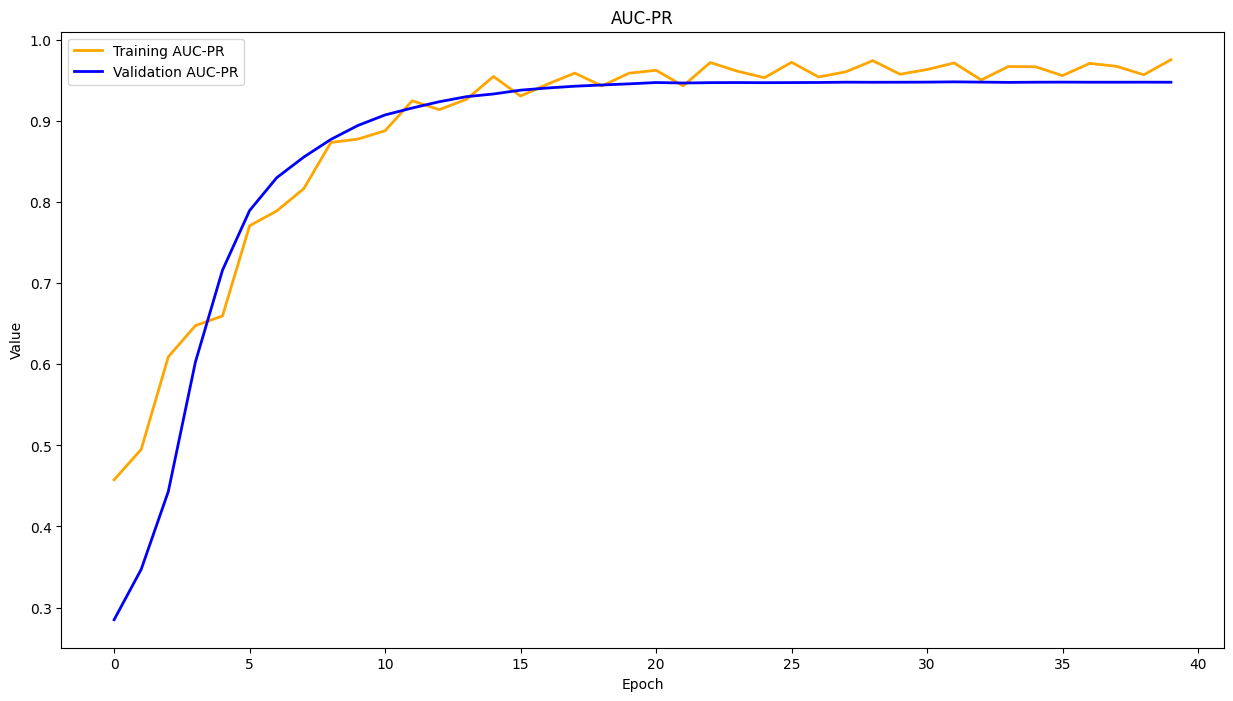

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['auc_pr'], label='Training AUC-PR', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_auc_pr'], label='Validation AUC-PR', color='blue', linewidth=2, markersize=6)
ax.set_title('AUC-PR')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')
ax.legend()

In [19]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix

val_prob = model.predict(X_val_window, batch_size=512).ravel()

# 2) Build sample weights to "simulate" TEST prevalence inside VAL
p_val = y_val_window.mean()     # ~0.360
p_target = 0.2092              # your TEST windowed positive rate

w_pos = p_target / p_val
w_neg = (1 - p_target) / (1 - p_val)

sample_weight = np.where(y_val_window == 1, w_pos, w_neg)

# 3) Get precision-recall curve under those weights
prec, rec, thr = precision_recall_curve(
    y_val_window, val_prob, sample_weight=sample_weight
)

# 4) Compute F1 for each threshold (thr has length N-1)
f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
best_i = np.argmax(f1)
best_thr = thr[best_i]

print("Best weighted threshold:", best_thr, "F1:", f1[best_i])


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Best weighted threshold: 0.6155479 F1: 0.8636647302733996


In [20]:
test_prob = model.predict(X_test_window, batch_size=512).ravel()
test_pred = (test_prob >= best_thr).astype(int)

print("Confusion matrix:\n", confusion_matrix(y_test_window, test_pred))
print(classification_report(y_test_window, test_pred, digits=3))


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion matrix:
 [[6523 1148]
 [ 670 1349]]
              precision    recall  f1-score   support

           0      0.907     0.850     0.878      7671
           1      0.540     0.668     0.597      2019

    accuracy                          0.812      9690
   macro avg      0.724     0.759     0.738      9690
weighted avg      0.830     0.812     0.819      9690

